In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import transforms as transforms
from torchvision.utils import make_grid


from scipy.stats import norm
from PIL import Image as PILImage
import scipy.ndimage
import cv2
from tqdm import trange, tqdm_notebook

import os
from os.path import join, dirname, exists
import warnings
warnings.filterwarnings('ignore')


Add Google Colab access to your Google Drive.

In [ ]:
def get_data_dir():
    return join('/content', 'drive', 'MyDrive', 'Thèse', 'Cours' , 'Session_5_Unsupervised')

In [ ]:
set_gpu_mode(True)
import importlib.util
spec = importlib.util.spec_from_file_location("pytorch_util", join(get_data_dir(),"pytorch_util.py"))
ptu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ptu)


##Learning framework

A bit more complicated due to the fact we have multiple networks
We also use this class to add useful methods as saving/loading a model

In [ ]:
class Solver(object):
    def __init__(self, train_data, n_iterations=50000, batch_size=256, n_filters=128):
        self.n_critic = 5
        self.log_interval = 100
        self.batch_size = batch_size
        self.n_filters = n_filters
        self.train_loader = self.create_loaders(train_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = self.n_critic * n_iterations // self.n_batches_in_epoch
        self.curr_itr = 0

    def build(self, part_name):
        self.g = Generator(n_filters=self.n_filters).to(ptu.device)
        self.d = Discriminator().to(ptu.device)
        self.g_optimizer = torch.optim.Adam(self.g.parameters(), lr=2e-4, betas=(0, 0.9))
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0, 0.9))
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(self.d_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.part_name = part_name

    def create_loaders(self, train_data):
        train_loader = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.shape[0]

        # Calculate interpolation
        eps = torch.rand(batch_size, 1, 1, 1).to(ptu.device)
        eps = eps.expand_as(real_data)
        interpolated = eps * real_data.data + (1 - eps) * fake_data.data
        interpolated.requires_grad = True

        d_output = self.d(interpolated)
        gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                        grad_outputs=torch.ones(d_output.size()).to(ptu.device),
                                        create_graph=True, retain_graph=True)[0]

        gradients = gradients.reshape(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return ((gradients_norm - 1) ** 2).mean()

    def train(self):
        train_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch', leave=False):
            epoch_i += 1

            self.d.train()
            self.g.train()
            self.batch_loss_history = []

            for batch_i, x in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
                batch_i += 1
                self.curr_itr += 1
                x = ptu.tensor(x).float()
                x = 2 * (x - 0.5)

                # do a critic update
                self.d_optimizer.zero_grad()
                fake_data = self.g.sample(x.shape[0])
                gp = self.gradient_penalty(x, fake_data)
                d_loss = self.d(fake_data).mean() - self.d(x).mean() + 10 * gp
                d_loss.backward()
                self.d_optimizer.step()
                # generator update
                if self.curr_itr % self.n_critic == 0:
                    self.g_optimizer.zero_grad()
                    fake_data = self.g.sample(self.batch_size)
                    g_loss = -self.d(fake_data).mean()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # step the learning rate
                    self.g_scheduler.step()
                    self.d_scheduler.step()

                    self.batch_loss_history.append(g_loss.data.cpu().numpy())

            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            np.save("q2_train_losses.npy", np.array(train_losses))

        train_losses = np.array(train_losses)
        self.save_model(f"{self.part_name}.pt")
        return train_losses

    def save_model(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)

    def load_model(self, filename):
        d_path = "d_" + filename
        g_path = "g_" + filename
        self.d.load_state_dict(torch.load(d_path))
        self.g.load_state_dict(torch.load(g_path))


## Validation

In [ ]:
def plot_gan_training(losses, title, fname):
    plt.figure()
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.plot(xs, losses, label='loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    if fname is not None:
        savefig(fname)
    else:
        plt.show()

def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()

##CIFAR-10

Look at the dataset

In [ ]:
def load_data():
    train_data = torchvision.datasets.CIFAR10("./data", transform=torchvision.transforms.ToTensor(),
                                              download=True, train=True)
    return train_data


def visualize_data():
    train_data = load_data()
    imgs = train_data.data[:100]
    show_samples(imgs, title=f'CIFAR-10 Samples')

Files already downloaded and verified


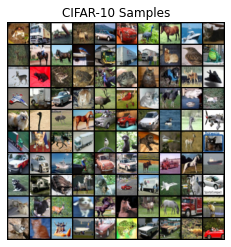

In [ ]:
visualize_data()

##Metrics

Inception model for Inception Score

In [ ]:
import torch
import torch.nn as nn


class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def forward_fid(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        return x

##WGAN-GP for CIFAR-10
* Gradient penalty to regularize the discriminator
* Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$
* Batch size of 256 and n_filters=128 within the ResBlocks
* Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training


Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states.

In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()

# Spatial Upsampling with Nearest Neighbors
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super(Upsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, x):
        _x = torch.cat([x, x, x, x], dim=1)
        _x = self.depth_to_space(_x)
        _x = self.conv(_x)
        return _x

# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super(Downsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.space_to_depth = SpaceToDepth(2)

    def forward(self, x):
        _x = self.space_to_depth(x)
        _x = sum(_x.chunk(4, dim=1)) / 4.0
        _x = self.conv(_x)
        return _x

Implement a residual block of 2 non linearities and 2 convolutions

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResBlock, self).__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, padding=1)
        ])

    def forward(self, x):
        _x = x
        for op in self.layers:
            _x = op(_x)
        return x + _x

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```




In [ ]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlockUp, self).__init__()
        self.layers = nn.ModuleList([
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1),
            Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        ])

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x

The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.



In [ ]:
class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), stride=1, n_filters=256):
        super(ResnetBlockDown, self).__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, stride=stride, padding=1),
            nn.ReLU(),
            Downsample_Conv2d(n_filters, n_filters, kernel_size),
            Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        ])

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```




In [ ]:
class Generator(nn.Module):
    def __init__(self, n_filters=256):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        ]
        self.net = nn.Sequential(*network)
        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

    def forward(self, z):
        z = self.fc(z).reshape(-1, 256, 4, 4)
        return self.net(z)

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).to(ptu.device)
        return self.forward(z)

Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockDown(3, n_filters=128),
            ResnetBlockDown(128, n_filters=128),
            ResBlock(128, n_filters=128),
            ResBlock(128, n_filters=128),
            nn.ReLU()
        ]
        self.net = nn.Sequential(*network)
        self.fc = nn.Linear(128, 1)

    def forward(self, z):
        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return self.fc(z)


In [ ]:
def SNGAN_CIFAR_train(train_data):
    solver = Solver(train_data, n_iterations=50000)
    solver.build("SNGAN_CIFAR")
    losses = solver.train()

    solver.g.eval()
    solver.d.eval()
    with torch.no_grad():
        samples = solver.g.sample(1000)
        samples = ptu.get_numpy(samples.permute(0, 2, 3, 1)) * 0.5 + 0.5

    return losses, samples


In [ ]:
def calculate_is(samples):
    assert (type(samples[0]) == np.ndarray)
    assert (len(samples[0].shape) == 3)
    data_dir = get_data_dir()

    model = GoogLeNet().to(ptu.device)
    model.load_state_dict(torch.load(join(data_dir,"classifier.pt")))
    softmax = nn.Sequential(model, nn.Softmax(dim=1))

    bs = 100
    softmax.eval()
    with torch.no_grad():
        preds = []
        n_batches = int(math.ceil(float(len(samples)) / float(bs)))
        for i in range(n_batches):
            sys.stdout.write(".")
            sys.stdout.flush()
            inp = ptu.FloatTensor(samples[(i * bs):min((i + 1) * bs, len(samples))])
            pred = ptu.get_numpy(softmax(inp))
            preds.append(pred)
    preds = np.concatenate(preds, 0)
    kl = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, 0), 0)))
    kl = np.mean(np.sum(kl, 1))
    return np.exp(kl)

In [ ]:
train_data = load_data()
train_data = train_data.data.transpose((0, 3, 1, 2)) / 255.0
train_losses, samples = SNGAN_CIFAR_train(train_data)

print("Inception score:", calculate_is(samples.transpose([0, 3, 1, 2])))
plot_gan_training(train_losses, 'WGAN-GP for CIFAR-10 Losses')
show_samples(samples[:100] * 255.0, title=f'CIFAR-10 generated samples')

Files already downloaded and verified
